Implemented using this, https://www.mdpi.com/2076-3417/12/4/1850

In [1]:
import os
import joblib
print(joblib.__version__)
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

1.3.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rnaseq = pd.read_csv('/content/drive/MyDrive/rnaseq/rnaseq_1.csv')
microRNA = pd.read_csv('/content/drive/MyDrive/microRNA/microRNA_1.csv')

Here's the strategy for now:

1. Convert all ages to a common unit (weeks is simplest).
2. For pcw, use the values directly as weeks.
3. For months, multiply the number of months by approximately 4.345 (the average number of weeks in a month) to convert to weeks.
4. For years, multiply the number of years by 52 (the number of weeks in a year) to convert to weeks.

In [43]:
def convert_age_to_weeks(age_str):
    if 'pcw' in age_str:
        return float(age_str.split(' ')[0])
    elif 'mos' in age_str:
        # convert months to weeks
        return float(age_str.split(' ')[0]) * 4.345
    elif 'yrs' in age_str or 'years' in age_str:
        # convert years to weeks
        return float(age_str.split(' ')[0]) * 52
    else:
        raise ValueError(f"Unknown age format: {age_str}")

In [17]:
def normalize_data(data, lower_bound=1, upper_bound=255):
    # spply threshold to filter out very low values
    threshold = data.mean().mean()
    data[data < threshold] = 0

    max_abs_value = data.abs().max().max()
    data_scaled = data.apply(lambda x: ((x / max_abs_value) * (upper_bound - lower_bound)) + lower_bound if x.max() != 0 else x, axis=1)
    return data_scaled

In [4]:
def convert_to_image(dataframe, image_size=150):
    total_size = image_size * image_size
    image_array = np.zeros((len(dataframe), total_size))

    for i, row in enumerate(dataframe.to_numpy()):
        image_array[i, :len(row)] = row[:total_size]

    # reshape to have it in 2D image format
    image_array = image_array.reshape(-1, image_size, image_size)

    return image_array

In [44]:
def preprocess_data(data_path, file_type='csv'):
    """
    Preprocess the data, normalize, convert to images, and return the train-test split.
    """

    if file_type == 'csv':
        data = pd.read_csv(data_path, index_col=0)
    elif file_type == 'excel':
        data = pd.read_excel(data_path, index_col=0)
    elif file_type == 'txt':
        data = pd.read_csv(data_path, sep='\t', index_col=0)
    else:
        raise ValueError("Unsupported file type")

    X = data.select_dtypes(include=[np.number])
    y = data['age']
    y_converted = y.apply(convert_age_to_weeks)

    # add a small value to avoid log(0)
    X_log_scaled = np.log1p(X)  # log1p applies log(1+x) to avoid log(0)
    max_log_value = X_log_scaled.max().max()
    X_normalized = np.round((X_log_scaled / max_log_value) * 255)
    print(X_normalized.iloc[:5, :10])

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_converted, test_size=0.2, random_state=42)

    X_train_images = convert_to_image(X_train)
    X_test_images = convert_to_image(X_test)

    return X_train_images, X_test_images, y_train, y_test

In [46]:
X_train_images, X_test_images, y_train, y_test = preprocess_data('/content/drive/MyDrive/rnaseq/rnaseq_1.csv')

                    1    2     3     4     5    6     7     8     9    10
donor_id                                                                 
H376.IIA.51_URL  66.0  9.0  50.0  28.0  14.0  9.0  18.0  51.0  33.0  52.0
H376.IIA.51_VFC  83.0  5.0  69.0  26.0  30.0  5.0  29.0  55.0  41.0  65.0
H376.IIA.51_DFC  92.0  5.0  76.0  31.0  34.0  8.0  27.0  59.0  38.0  61.0
H376.IIA.51_LGE  76.0  2.0  60.0  29.0  31.0  2.0   4.0  51.0  32.0  64.0
H376.IIA.51_ITC  74.0  0.0  62.0  31.0  22.0  5.0  20.0  53.0  38.0  65.0


In [49]:
X_train_images

array([[[28.,  3., 49., ..., 44., 14., 18.],
        [43.,  0., 24., ..., 15., 18., 33.],
        [54., 34., 79., ..., 44., 32., 26.],
        ...,
        [55.,  0.,  0., ...,  4.,  1., 30.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[37.,  0., 42., ..., 22., 11.,  9.],
        [17.,  1.,  3., ...,  3., 12.,  1.],
        [ 7.,  7., 89., ..., 20., 14.,  5.],
        ...,
        [46.,  0.,  0., ...,  4.,  1., 46.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[52.,  1., 56., ..., 43., 26.,  5.],
        [68.,  0., 35., ..., 23.,  4., 11.],
        [62., 63., 28., ..., 55., 72., 61.],
        ...,
        [65.,  0.,  1., ...,  1.,  0., 14.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[25.,  3., 34., ..., 19.,  5.,  9.],
        [17.,  0.,  4., ...,  7., 10.,  8.],
        [14., 10., 70., ..., 10., 10., 13.

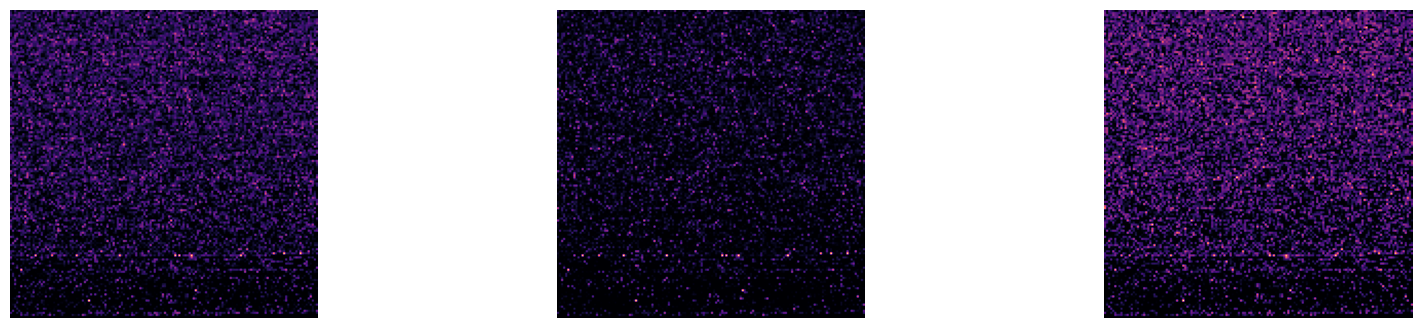

In [50]:
def plot_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='magma')
        ax.axis('off')
    plt.show()

plot_images(X_train_images, num_images=3)

## CNN

In [51]:
def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# ddd a channels dimension to the images
X_train_images_expanded = np.expand_dims(X_train_images, axis=-1)
X_test_images_expanded = np.expand_dims(X_test_images, axis=-1)

print(X_train_images_expanded.shape)

# ddjust the input shape for the CNN
input_shape = X_train_images_expanded.shape[1:]
num_classes = len(np.unique(y_train))

cnn_model = create_cnn(input_shape, num_classes)

(462, 150, 150, 1)


In [53]:
def create_cnn_regression(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')  # single output node for regression
    ])

    return model

cnn_model_regression = create_cnn_regression(input_shape)

cnn_model_regression.compile(
    optimizer='adam',
    loss='mean_squared_error',  # loss function for regression
    metrics=['mean_squared_error']
)

history = cnn_model_regression.fit(
    X_train_images_expanded, y_train,
    validation_data=(X_test_images_expanded, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
15/15 [==============================] - 22s 1s/step - loss: 522426.5000 - mean_squared_error: 522426.5000 - val_loss: 507348.0312 - val_mean_squared_error: 507348.0312
Epoch 2/10
15/15 [==============================] - 19s 1s/step - loss: 444076.2188 - mean_squared_error: 444076.2188 - val_loss: 420750.6875 - val_mean_squared_error: 420750.6875
Epoch 3/10
15/15 [==============================] - 19s 1s/step - loss: 397009.4062 - mean_squared_error: 397009.4062 - val_loss: 345294.6562 - val_mean_squared_error: 345294.6562
Epoch 4/10
15/15 [==============================] - 23s 2s/step - loss: 313200.3125 - mean_squared_error: 313200.3125 - val_loss: 266511.2500 - val_mean_squared_error: 266511.2500
Epoch 5/10
15/15 [==============================] - 20s 1s/step - loss: 282244.8438 - mean_squared_error: 282244.8438 - val_loss: 218334.8438 - val_mean_squared_error: 218334.8438
Epoch 6/10
15/15 [==============================] - 19s 1s/step - loss: 228195.5781 - mean_squared_e